In [1]:
# The standard Python science stack
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
from scipy.sparse.linalg import lsqr

# Plotting maps using GMT
import pygmt

# The Fatiando stack
import harmonica as hm
from grav_column_der import grav_column_der

# RIS tight extent
# e_fig = -560000
# w_fig = 400000
# n_fig = -1400000
# s_fig = -440000

# RIS zoomed in extent
zoom = 300e3
e_fig = -560000+zoom
w_fig = 400000-zoom
n_fig = -1400000+zoom
s_fig = -440000-zoom

fig_reg = [e_fig, w_fig, n_fig, s_fig]

fig_height = 80
fig_width = fig_height*(w_fig-e_fig)/(s_fig-n_fig)
fig_ratio = (s_fig-n_fig)/(fig_height/1000)
fig_proj = f"x1:{fig_ratio}"

# buffer = (w_fig - e_fig) 
buffer = 200e3

e_inv = int(e_fig-buffer)
w_inv = int(w_fig+buffer)
n_inv = int(n_fig-buffer)
s_inv = int(s_fig+buffer)
inv_reg = [e_inv, w_inv, n_inv, s_inv]
inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'

inv_height = 80
inv_width = inv_height*(w_inv-e_inv)/(s_inv-n_inv)
inv_ratio = (s_inv-n_inv)/(inv_height/1000)
inv_proj = f"x1:{inv_ratio}"

# To Do
* use discretize package to increase grid spacing outside of fig_reg
* implement scipy optimize to compare with grav_column_der
* add control points to bathymetry
* implement vertically increasing density to both ice and sediment (like harmonica.tesseroid_gravity)

# Import data

In [2]:
inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'

layers_list =[
             'ice',
             'water',
             'layer1',
             'layer2',
]
spacing_list = [
                10e3,
                10e3,
                10e3,
                10e3,
]
rho_list = [
            920,
            1030,
            2600,
            2800,
]

grav_spacing = 10e3

# Bedmachine grids
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{grav_spacing}  gravity_data/ant4d_gravity.nc -Ginversion_layers/gravity_inv.nc
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[0]}  inversion_layers/bedmachine/BedMachine_surface_5k_filled.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[1]}  inversion_layers/bedmachine/BedMachine_icebase_5k_filled.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[2]}  inversion_layers/bedmachine/BedMachine_bed_5k.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[3]}  inversion_layers/RE_basement_BedMachinebed_filled.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 
!gmt grdsample -R{inv_reg_str} -rg -Vn -I{spacing_list[3]}  inversion_layers/ANTASed_mag_basement_filled.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 

# Fabio's test grids
# inv_reg_str=f'{e_inv}/{w_inv}/{n_inv}/{s_inv}'
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_gravity_10000m_lr.nc -Ginversion_layers/gravity_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_ice_10000m_lr.nc -Ginversion_layers/BedMachine_surface_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_water_10000m_lr.nc -Ginversion_layers/BedMachine_icebase_filled_inv.nc
# !gmt grdsample -R{inv_reg_str} -rg -I10e3  inversion_layers/base_RIS_layer1_10000m_lr.nc -Ginversion_layers/BedMachine_bed_inv.nc 
# !gmt grdsample -R{inv_reg_str} -rg -I20e3  inversion_layers/base_RIS_layer2_20000m_lr.nc -Ginversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc 

fname_list=[
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_surface_filled_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_icebase_filled_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_bed_inv.nc',
            'C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc',
            ]

layers = {j:{'spacing':spacing_list[i], 
            'fname':fname_list[i], 
            'rho':rho_list[i]} for i, j in enumerate(layers_list)}

for k, v in layers.items():
    v['grid']=xr.load_dataset(v['fname'])
    v['df']=xr.load_dataset(v['fname']).to_dataframe().reset_index()
    v['df']['rho']=v['rho']
    v['df'].dropna(how='any', inplace=True)
    v['len']=len(v['df'].x)  

fname='C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/gravity_inv.nc'
grid_grav = xr.load_dataset(fname)           
df_grav = xr.load_dataset(fname).to_dataframe().reset_index() 
df_grav.rename(columns={'z':'Gobs'}, inplace=True)
df_grav.dropna(how='any', inplace=True)
df_grav['z']=layers['ice']['grid'].to_dataframe().reset_index().z+750

for k, v in layers.items():
    print(f"points in {k} file: {v['len']}") 

print(f'points in gravity file: {len(df_grav)}')    

points in ice file: 5929
points in water file: 5929
points in layer1 file: 5929
points in layer2 file: 5929
points in gravity file: 5929


# Show layers

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


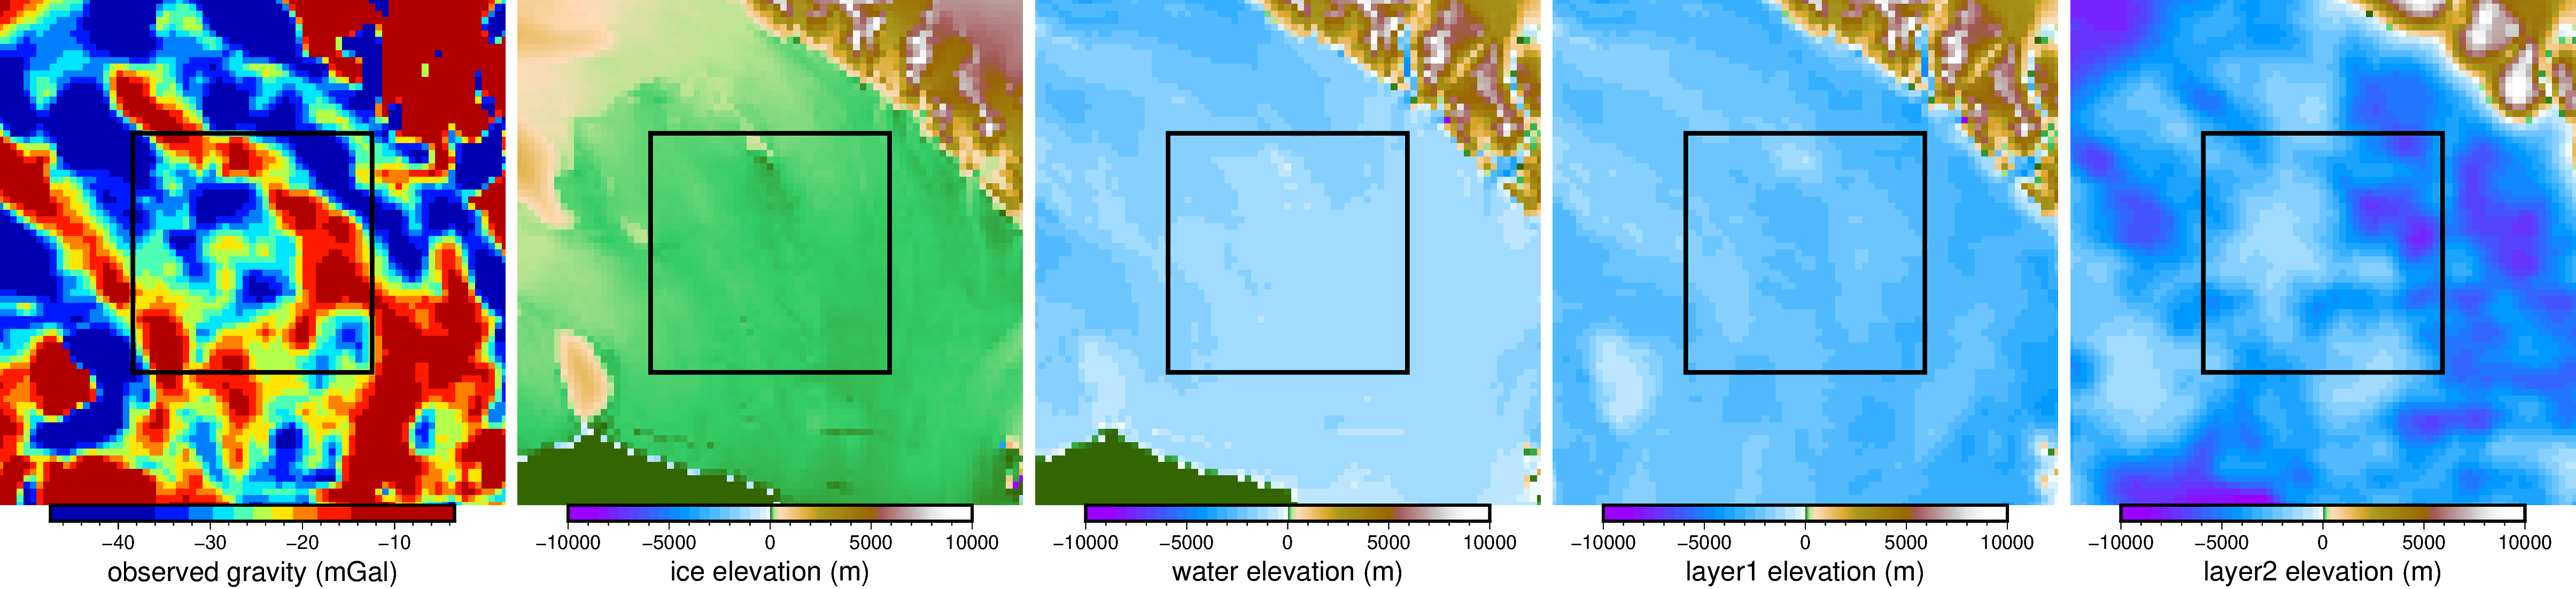

In [3]:
fig = pygmt.Figure()

pygmt.grd2cpt(cmap="jet", grid=grid_grav.z, region=fig_reg, background=True)
fig.grdimage(
    grid_grav.z,
    cmap=True,
    projection=inv_proj, 
    region=inv_reg,
    nan_transparent=True,
    frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='x+l"observed gravity (mGal)"')
# plot later figure extents (without inv buffer)
fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
             pen = '2p,black')

fig.shift_origin(xshift=(inv_width+2)/10)

for i, (k, v) in enumerate(layers.items()):
    data=layers[k]['grid'].z
    fig.grdimage(
        data,
        cmap='globe',
        projection=inv_proj, 
        region=inv_reg,
        nan_transparent=True,
        frame=['+gwhite'])
    fig.colorbar(cmap='globe', position='jBC+jTC+h', frame=f'x+l"{k} elevation (m)"')

    # plot later figure extents (without inv buffer)
    fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
             pen = '2p,black')
             
    fig.shift_origin(xshift=(inv_width+2)/10)
    # if i+1 == len(layers)//2:
    #     fig.shift_origin(yshift=(-inv_height-15)/10, xshift=((-inv_width-2)*1.5)/10)
    # else:
    #     fig.shift_origin(xshift=(inv_width+2)/10)
fig.show()

# Forward gravity calculations of layers

In [4]:
# Calculate inital forward gravity model of input layer
# add density variable to datasets
for k ,v in layers.items():
    v['grid']['density']=v['grid'].z.copy()
    v['grid'].density.values[:] = v['rho']

# list of layers, bottom up
reversed_layers_list = np.flip(layers_list[:])

for i, j in enumerate(reversed_layers_list):
    if i == 0:
        layers[j]['prisms']=hm.prism_layer(
            coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
            surface=layers[j]['grid'].z, 
            reference=-20e3,
            properties={'density':layers[j]['grid'].density})
        print(f'mean elevation of {j} top: {layers[j]["prisms"].top.values.mean()} and bottom: {layers[j]["prisms"].bottom.values.mean()}')

    else:
        if layers[j]['spacing'] != layers[reversed_layers_list[i-1]]['spacing']:
            print(f"resolutions don't match for {j} ({layers[j]['spacing']}m) and {reversed_layers_list[i-1]} ({layers[reversed_layers_list[i-1]]['spacing']}m)")
            print(f"resampling {reversed_layers_list[i-1]} to match {j}")
            tmp = layers[j]['grid'].z.to_dataframe().reset_index()
            tmp_regrid = pygmt.grdtrack(points = tmp[['x','y']], 
                                        grid = layers[reversed_layers_list[i-1]]['grid'].z, 
                                        newcolname = 'z_regrid')
            tmp['z_low']=tmp.merge(tmp_regrid, how = 'left', on = ['x','y']).z_regrid
            tmp_grd = pygmt.xyz2grd(tmp[['x','y','z_low']], region = inv_reg, spacing = layers[j]['spacing'])

            layers[j]['prisms']=hm.prism_layer(
                coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                surface=layers[j]['grid'].z, 
                reference=tmp_grd,
                properties={'density':layers[j]['grid'].density})
            print(f'mean elevation of {j} top: {layers[j]["prisms"].top.values.mean()} and bottom: {layers[j]["prisms"].bottom.values.mean()}')
        else:
            layers[j]['prisms']=hm.prism_layer(
                coordinates=(list(layers[j]['grid'].x), list(layers[j]['grid'].y)),   
                surface=layers[j]['grid'].z, 
                reference=layers[reversed_layers_list[i-1]]['grid'].z,
                properties={'density':layers[j]['grid'].density})
            print(f'mean elevation of {j} top: {layers[j]["prisms"].top.values.mean()} and bottom: {layers[j]["prisms"].bottom.values.mean()}')

print('starting forward gravity calculations')
for k, v in layers.items():
    df_grav[f'{k}_forward_grav'] = v['prisms'].prism_layer.gravity(
        coordinates = (df_grav.x, df_grav.y, df_grav.z),
        field = 'g_z', progressbar=True)
    print(f'finished {k} layer')

# add gravity effects of all input layers
for i, j in enumerate(layers_list):
    if i == 0:
        df_grav['forward_grav_total'] = df_grav[f'{j}_forward_grav']
    else:
        df_grav['forward_grav_total'] += df_grav[f'{j}_forward_grav']

df_grav.describe()


mean elevation of layer2 top: -2040.60107421875 and bottom: -20000.0
mean elevation of layer1 top: -381.54229736328125 and bottom: -2045.470458984375
mean elevation of water top: -170.70944213867188 and bottom: -386.4454040527344
mean elevation of ice top: 243.7149658203125 and bottom: -170.9807586669922
starting forward gravity calculations
100%|██████████| 5929.0/5929 [00:04<00:00, 1377.33it/s]
finished ice layer
100%|██████████| 5929.0/5929 [00:02<00:00, 2375.44it/s]
finished water layer
100%|██████████| 5929.0/5929 [00:02<00:00, 2368.86it/s]
finished layer1 layer
100%|██████████| 5929.0/5929 [00:02<00:00, 2043.52it/s]
finished layer2 layer


,x,y,Gobs,z,ice_forward_grav,water_forward_grav,layer1_forward_grav,layer2_forward_grav,forward_grav_total
count,5929.000000,5.929000e+03,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000,5929.000000
mean,-80000.000000,-9.200000e+05,-22.086596,993.477295,15.835347,9.224086,176.845641,1928.446372,2130.351447
std,222279.853638,2.222799e+05,25.693026,572.902893,9.772905,7.982091,94.919600,215.902781,184.532452
min,-460000.000000,-1.300000e+06,-167.969986,720.279602,0.022625,0.005958,1.407654,718.160639,1033.623677
25%,-270000.000000,-1.110000e+06,-32.610622,785.942627,12.178518,0.579963,102.321818,1856.202071,2114.766577
50%,-80000.000000,-9.200000e+05,-24.935623,793.166748,14.269923,8.712476,171.728000,1963.820733,2193.983368
75%,110000.000000,-7.300000e+05,-15.802500,823.660950,19.503376,15.651328,245.535458,2065.614620,2222.623625
max,300000.000000,-5.400000e+05,166.949997,4540.032227,86.727899,29.485500,453.186483,2503.778464,2586.048893


# Plot forward gravity of each layer

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


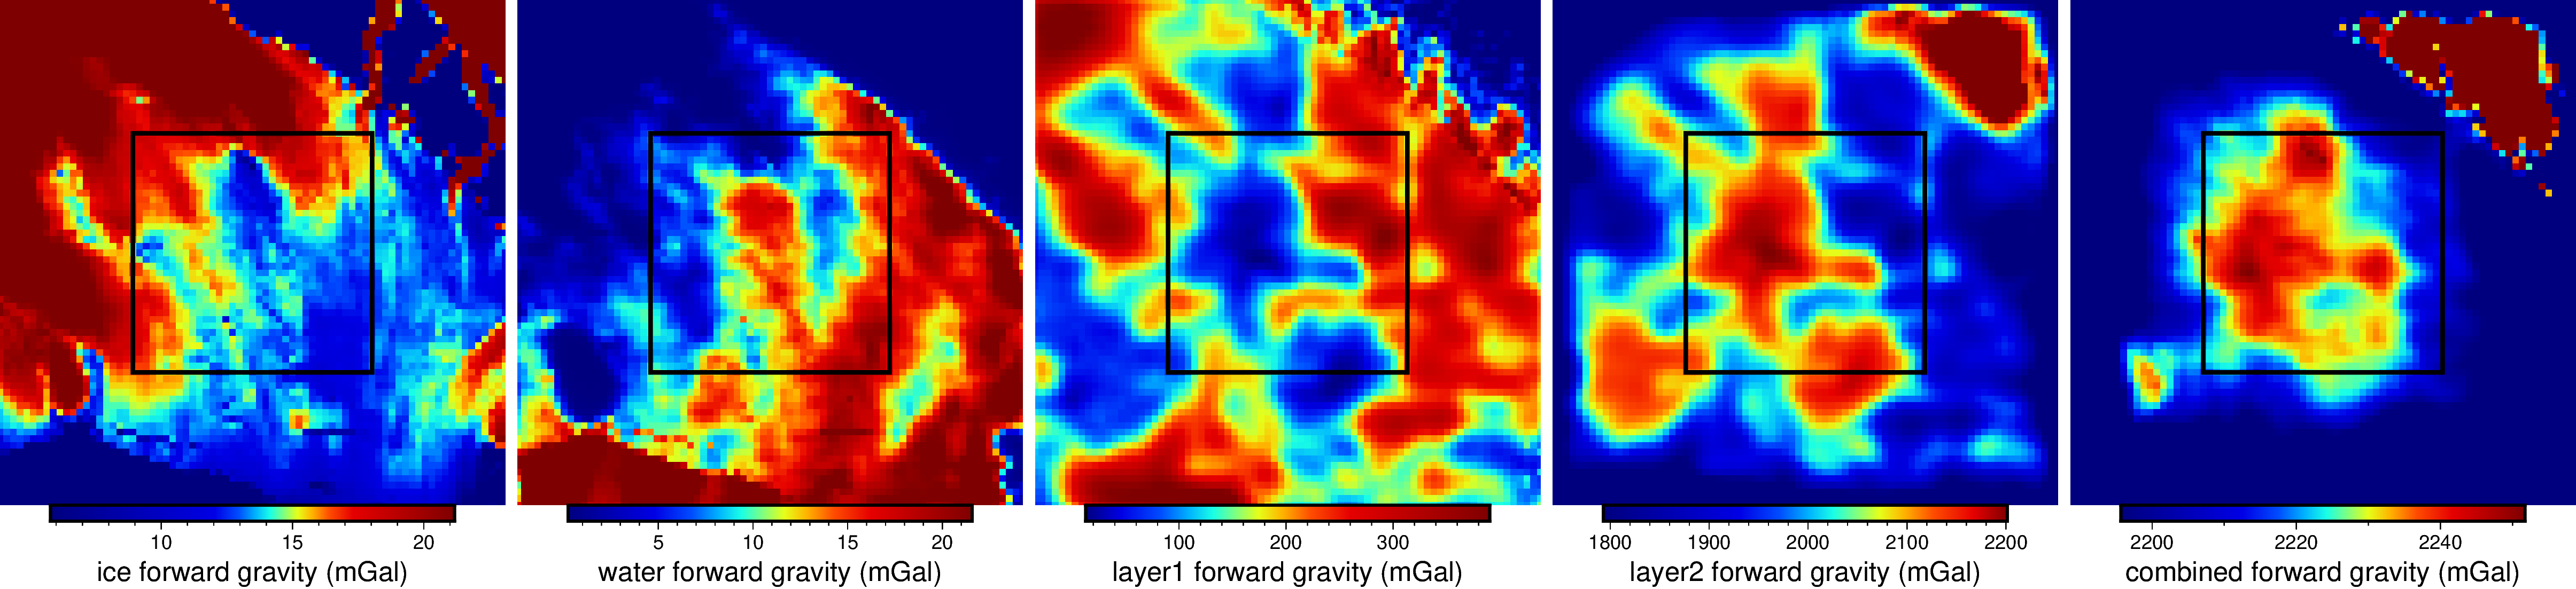

In [5]:
fig = pygmt.Figure()

for i, (k, v) in enumerate(layers.items()):
    data = pygmt.xyz2grd(data=df_grav[['x','y',f'{k}_forward_grav']],
                         region=inv_reg, spacing=grav_spacing, projection=inv_proj) 
    pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
    fig.grdimage(
        data,
        cmap=True,
        projection=inv_proj, 
        region=inv_reg,
        nan_transparent=True,
        frame=['+gwhite'])
    fig.colorbar(cmap=True, position='jBC+jTC+h', frame=f'x+l"{k} forward gravity (mGal)"')
    
    # plot later figure extents (without inv buffer)
    fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
             pen = '2p,black')

    fig.shift_origin(xshift=(fig_width+2)/10)

    # if i+1 == len(layers)//2:
    #     fig.shift_origin(yshift=(-fig_height-15)/10, xshift=((-fig_width-2)*1)/10)
    # else:
    #     fig.shift_origin(xshift=(fig_width+2)/10)

data = pygmt.xyz2grd(data=df_grav[['x','y', 'forward_grav_total']],
                         region=inv_reg, spacing=grav_spacing, projection=inv_proj) 
pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True, continuous=True)
fig.grdimage(
    data,
    cmap=True,
    projection=inv_proj, 
    region=inv_reg,
    nan_transparent=True,
    frame=['+gwhite'])
fig.colorbar(cmap=True, position='jBC+jTC+h', frame='x+l"combined forward gravity (mGal)"')

# plot later figure extents (without inv buffer)
fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
            y = [n_fig, s_fig, s_fig, n_fig, n_fig], 
            pen = '2p,black')
            
fig.show()

# Plot observed, misfit, and forward gravity 

average initial misfit within figure region is -2252 mGal
average Gobs_shifted: 2227 mGal
average misfit between Gobs_shift and forward gravity within figure region is 0 mGal


psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


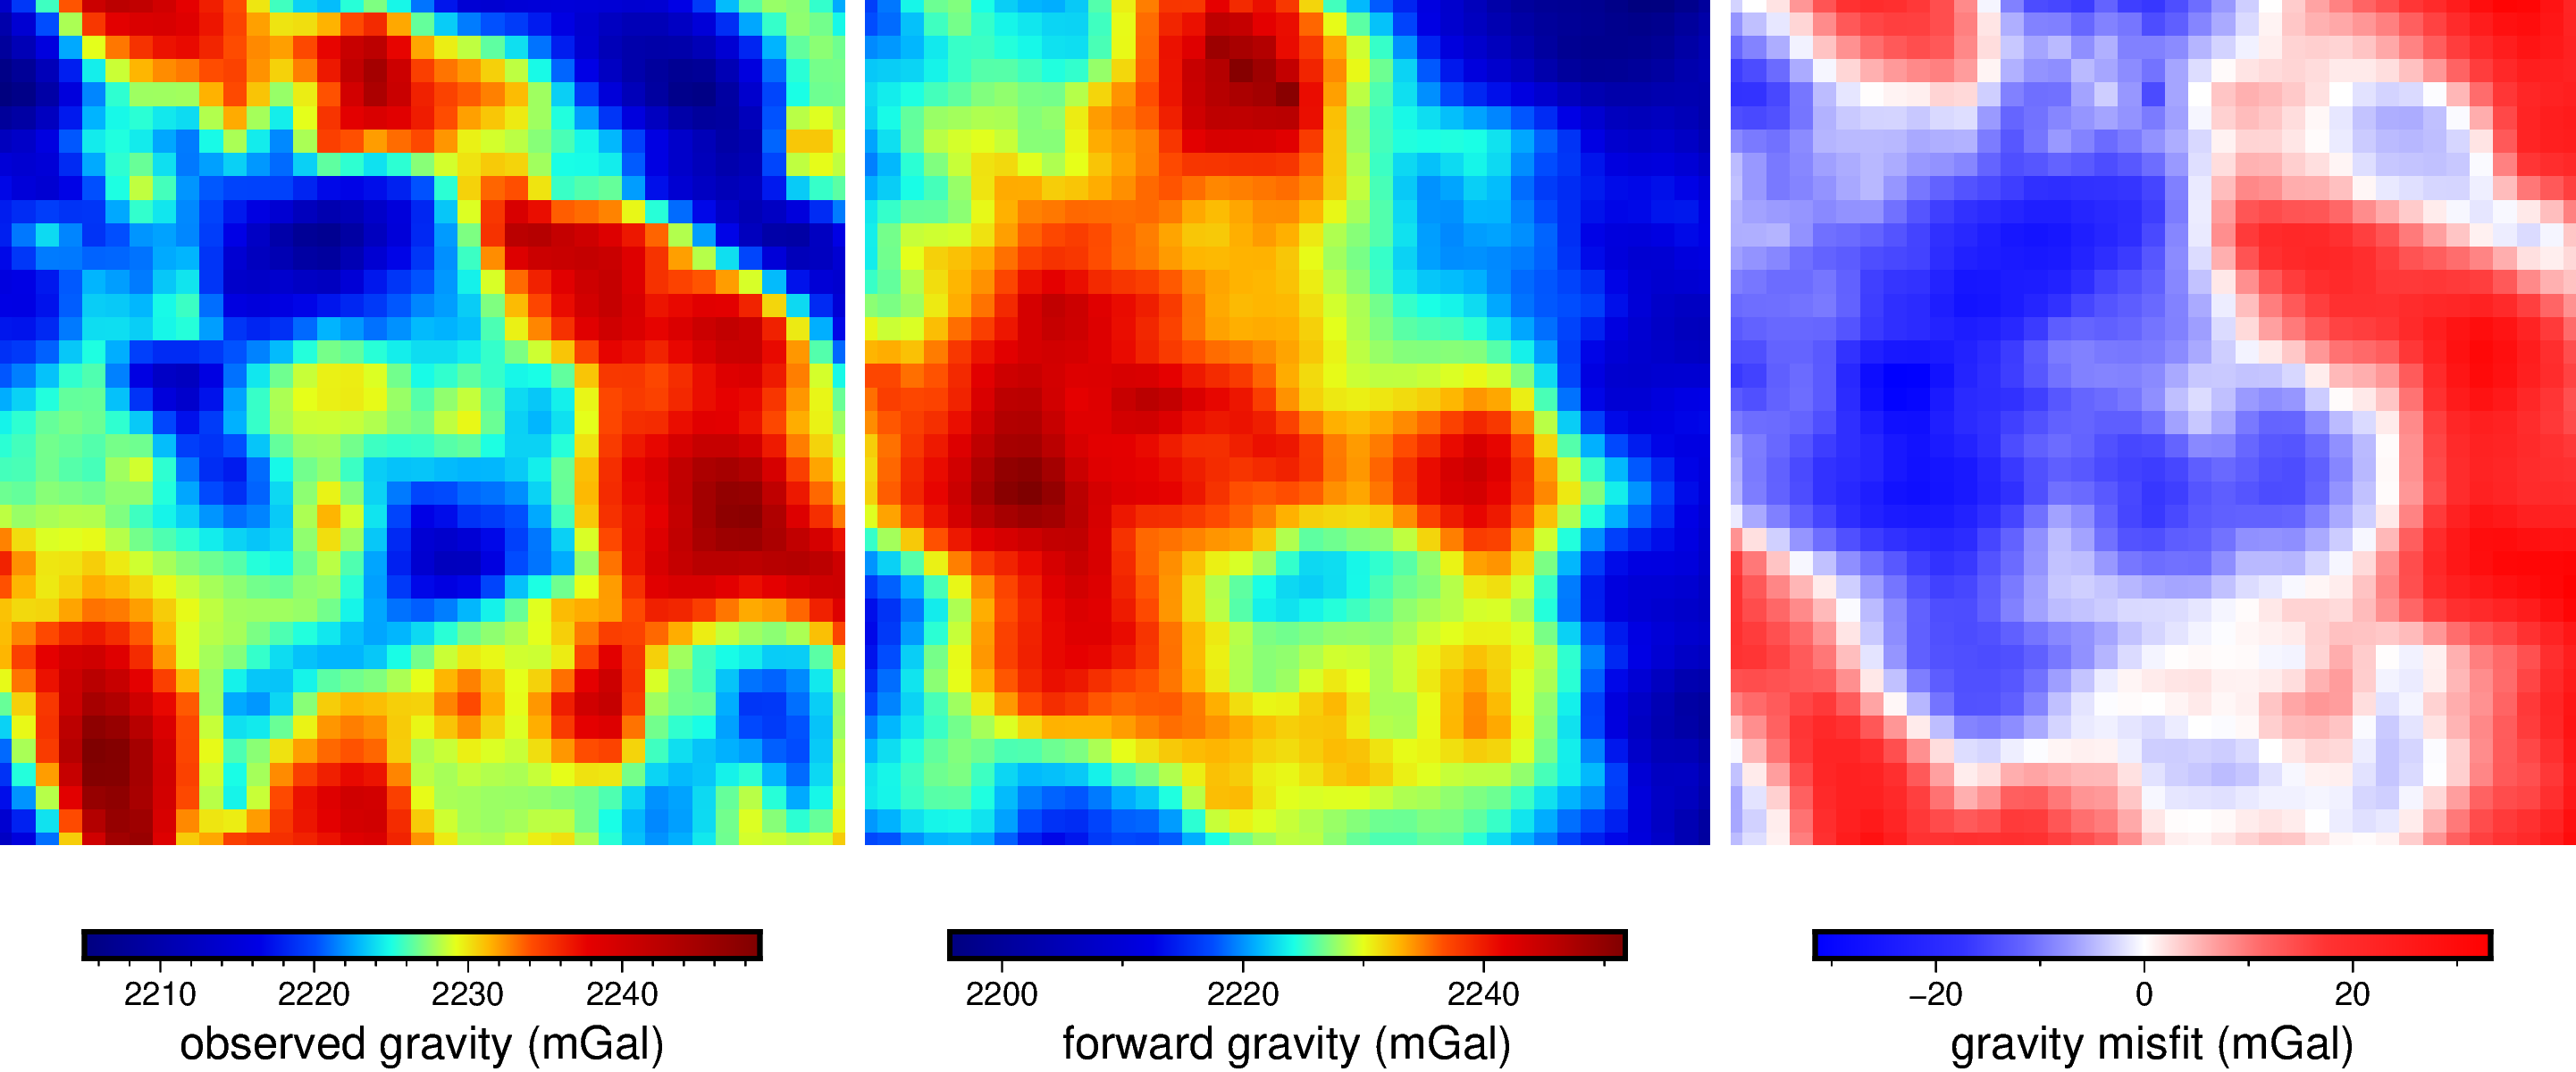

In [6]:
# plot observed, forward, and misfit gravity grids

df_grav['initial_misfit'] = df_grav.Gobs - df_grav.forward_grav_total
shift = df_grav.initial_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
print(f'average initial misfit within figure region is {int(shift)} mGal')

df_grav['Gobs_shift'] = df_grav.Gobs - shift
print(f'average Gobs_shifted: {int(df_grav.Gobs_shift[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean())} mGal')

df_grav['forward_grav_misfit'] = df_grav.Gobs_shift - df_grav.forward_grav_total
misfit_shift = df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean() 
print(f'average misfit between Gobs_shift and forward gravity within figure region is {int(misfit_shift)} mGal')

# print(f'average forward gravity total: {int(df_grav.forward_grav_total[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean())} mGal')

observed_shift_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','Gobs_shift']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

forward_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_total']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)

misfit_grav_grid=pygmt.xyz2grd(data = df_grav[['x','y','forward_grav_misfit']],
                                 region=inv_reg, 
                                 spacing=grav_spacing,
                                 projection=inv_proj)


fig = pygmt.Figure()

# plot observed gravity
grid=observed_shift_grav_grid
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"observed gravity (mGal)"')

fig.shift_origin(xshift=(fig_width+2)/10)

# plot forward gravity
grid=forward_grav_grid
pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"forward gravity (mGal)"')


fig.shift_origin(xshift=(fig_width+2)/10)

# plot misfit gravity
grid=misfit_grav_grid
pygmt.grd2cpt(cmap="polar+h0", grid=grid, region=fig_reg, background=True, continuous=True)
fig.grdimage(
        grid,
        cmap=True,#'polar+h0',
        projection=fig_proj, 
        region=fig_reg,
        nan_transparent=True,
        frame=['+gwhite'])
fig.colorbar(cmap=True, frame='af+l"gravity misfit (mGal)"')

fig.show()

# Prism geometry inversion

In [7]:
# df_grav_inner

In [8]:
# active_layer = 'layer1'
# MATDATPAR = (np.zeros([len(df_grav_inner),len(prisms)]))
# MATDATPAR[]df_grav_inner['forward_grav_{active_layer}_test'] = layers[active_layer]['prisms'].prism_layer.gravity(
#     coordinates=(df_grav_inner.x, df_grav_inner.y, df_grav_inner.z),
#     field = 'g_z', progressbar=True)
# df_grav_inner['forward_grav_{active_layer}_test']    
# [i,0:len(prisms)]

In [9]:
# MATDATPAR.shape

In [10]:
# MATDATPAR[0].shape

In [22]:
layers[active_layer]['prisms_der'].to_dataframe().reset_index()

,northing,easting,density,top,bottom
0,-1300000.0,-460000.0,2600.0,-520.091553,-1076.908569
1,-1300000.0,-450000.0,2600.0,-696.380981,-1244.474976
2,-1300000.0,-440000.0,2600.0,-771.025818,-1490.202637
3,-1300000.0,-430000.0,2600.0,-744.822571,-1797.020142
4,-1300000.0,-420000.0,2600.0,-746.841980,-2158.236572
...,...,...,...,...,...
5924,-540000.0,260000.0,2600.0,961.223694,904.839294
5925,-540000.0,270000.0,2600.0,844.495667,800.381958
5926,-540000.0,280000.0,2600.0,663.397278,577.128418
5927,-540000.0,290000.0,2600.0,513.374512,419.038574


In [32]:
active_layer='layer1'
df_grav['grav_inversion']=df_grav.Gobs_shift
df_grav_inner = df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()

layers[active_layer]['prisms_der'] = layers[active_layer]['prisms'].copy()

layers[active_layer]['prisms_der'].prism_layer.update_top_bottom(layers[active_layer]['prisms_der'].top-100, layers[active_layer]['prisms_der'].bottom)


# MATDATPAR = (np.zeros([len(df_grav_inner),len(prisms)]))
# for i,j in enumerate(tqdm(df_grav_inner.Gobs)):
df_grav_inner['forw1'] = layers[active_layer]['prisms'].prism_layer.gravity(
            coordinates = (df_grav_inner.x, df_grav_inner.y, df_grav_inner.z),
            field = 'g_z') 
df_grav_inner['forw2'] = layers[active_layer]['prisms_der'].prism_layer.gravity(
                coordinates=(df_grav_inner.x, df_grav_inner.y, df_grav_inner.z),
                field = 'g_z')
df_grav_inner['deriv'] = (df_grav_inner.forw1 - df_grav_inner.forw2) / 100 
    # MATDATPAR[i,0:len(prisms)] = layers[active_layer]['prisms'].prism_layer.gravity(
    #     coordinates=(df_grav_inner.x.iloc[i], df_grav_inner.y.iloc[i], df_grav_inner.z.iloc[i]),
    #     field = 'g_z', progressbar=False)



In [34]:
df_grav_inner.describe()

,x,y,Gobs,z,ice_forward_grav,water_forward_grav,layer1_forward_grav,layer2_forward_grav,forward_grav_total,initial_misfit,Gobs_shift,forward_grav_misfit,grav_inversion,forw1,forw2,deriv
count,1369.0000,1.369000e+03,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000,1369.000000
mean,-80000.0000,-9.200000e+05,-25.348761,790.990051,14.667913,10.510769,152.986182,2048.918232,2227.083096,-2252.431855,2227.083252,0.000030,2227.083252,152.986182,142.155633,0.108305
std,106809.7998,1.068098e+05,8.311746,7.348218,2.055531,4.456777,83.341681,92.269277,11.368294,13.584611,8.311746,13.584612,8.311746,83.341681,83.303765,0.003480
min,-260000.0000,-1.100000e+06,-47.360001,762.503174,5.783785,0.238311,12.833148,1793.006666,2195.658795,-2284.016698,2205.071777,-31.584795,2205.071777,12.833148,6.699652,0.022362
25%,-170000.0000,-1.010000e+06,-30.428123,786.431396,13.159134,7.197453,87.317861,1989.519468,2220.266223,-2262.952355,2222.003662,-10.520482,2222.003662,87.317861,76.431927,0.108239
50%,-80000.0000,-9.200000e+05,-25.539373,790.107727,14.450894,10.432395,143.089632,2063.834452,2228.450314,-2253.725964,2226.892578,-1.294167,2226.892578,143.089632,132.197622,0.108500
75%,10000.0000,-8.300000e+05,-19.841875,794.786621,16.133380,13.910851,204.845250,2122.253831,2235.167898,-2242.668413,2232.590088,9.763569,2232.590088,204.845250,193.967367,0.108797
max,100000.0000,-7.400000e+05,-3.490001,877.331604,21.170174,21.570819,390.261347,2201.449044,2251.726012,-2219.223578,2248.941895,33.208414,2248.941895,390.261347,379.388951,0.111297


In [40]:
prisms_inner = prisms[(prisms.easting.between(e_fig, w_fig)) & (prisms.northing.between(n_fig, s_fig))].copy()
MATDATPAR = (np.zeros([len(df_grav_inner),len(prisms_inner)]))
for i,j in enumerate(tqdm(df_grav_inner.Gobs)):
    MATDATPAR[i,0:len(prisms)]=df_grav_inner.deriv
MATDATPAR

100%|██████████| 1369/1369 [00:00<00:00, 26648.98it/s]


array([[0.10794053, 0.10801424, 0.10851252, ..., 0.10756887, 0.10737401,
        0.10717847],
       [0.10794053, 0.10801424, 0.10851252, ..., 0.10756887, 0.10737401,
        0.10717847],
       [0.10794053, 0.10801424, 0.10851252, ..., 0.10756887, 0.10737401,
        0.10717847],
       ...,
       [0.10794053, 0.10801424, 0.10851252, ..., 0.10756887, 0.10737401,
        0.10717847],
       [0.10794053, 0.10801424, 0.10851252, ..., 0.10756887, 0.10737401,
        0.10717847],
       [0.10794053, 0.10801424, 0.10851252, ..., 0.10756887, 0.10737401,
        0.10717847]])

In [44]:
active_layer = 'layer1'
prisms = layers[active_layer]['prisms'].to_dataframe().reset_index()
df_grav['grav_inversion']=df_grav.Gobs_shift
df_grav_inner = df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()

df_grav_inner['inv_misfit']=df_grav_inner.grav_inversion-df_grav_inner[f'forward_grav_total']


MATDATPAR = (np.zeros([len(df_grav_inner),len(prisms)]))
for i,j in enumerate(tqdm(df_grav_inner.Gobs)):
    MATDATPAR[i,0:len(prisms)] = layers[active_layer]['prisms'].prism_layer.gravity(
        coordinates=(df_grav_inner.x.iloc[i], df_grav_inner.y.iloc[i], df_grav_inner.z.iloc[i]),
        field = 'g_z', progressbar=False)

Surface_correction=lsqr(MATDATPAR,df_grav_inner['inv_misfit'],show=False)[0] # finds the least-squares solution to MATDATPAR and Grav_Misfit, assigns the first value to Surface_correction
pd.Series(Surface_correction).describe()

count    5.929000e+03
mean     4.582006e-06
std      8.471044e-22
min      4.582006e-06
25%      4.582006e-06
50%      4.582006e-06
75%      4.582006e-06
max      4.582006e-06
dtype: float64

In [ ]:
#########
active_layer = 'layer1'
#########

prisms = layers[active_layer]['prisms'].to_dataframe().reset_index()
# prisms_inner = prisms[(prisms.easting.between(e_fig, w_fig)) & (prisms.northing.between(n_fig, s_fig))].copy()

df_grav['grav_inversion']=df_grav.Gobs_shift
df_grav_inner = df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].copy()

spacing = layers[active_layer]['spacing'] 
misfit_sq_tolerance=.005
delta_misfit_squared_tolerance=0.02
Max_Iterations=1
max_layer_change_per_iter=250 

MATDATPAR = (np.zeros([len(df_grav_inner),len(prisms)]))

misfit_squared_updated=np.Inf  # positive infinity
delta_misfit_squared=np.Inf  # positive infinity

df_grav_inner['inv_misfit']=df_grav_inner.grav_inversion-df_grav_inner[f'forward_grav_total']

ITER=0
 # while delta_misfit_squared (inf) is greater than 1 + least squares tolerance (0.02)
while delta_misfit_squared > 1+delta_misfit_squared_tolerance:
    ITER=ITER+1 
    print(f"iteration {ITER}")

    # get prisms' coordinates from active layer
    prisms = layers[active_layer]['prisms'].to_dataframe().reset_index()
    prisms_der = layers[active_layer]['prisms'].to_dataframe().reset_index()

    # calculate MATDATPAR with approximation of gravity vertical derivative
    print('calculating Jacobian matrix to determine surface correction')
    # make prisms tops 100m higher
    prisms_der.top=prisms_der.top-10
    layers[active_layer]['prisms_der'] = layers[active_layer]['prisms']
    layers[active_layer]['prisms_der'].prism_layer.update_top_bottom(pygmt.xyz2grd(prisms_der[['easting','northing','top']], 
                                region=inv_reg, spacing=spacing), layers[active_layer]['prisms_der'].bottom)
    for i,j in enumerate(tqdm(df_grav_inner.Gobs)):
        MATDATPAR[i,0:len(prisms_der)] = ( ( (layers[active_layer]['prisms'].prism_layer.gravity(
            coordinates=(df_grav_inner.x.iloc[i], df_grav_inner.y.iloc[i], df_grav_inner.z.iloc[i]),
            field = 'g_z') ) - (layers[active_layer]['prisms_der'].prism_layer.gravity(
            coordinates=(df_grav_inner.x.iloc[i], df_grav_inner.y.iloc[i], df_grav_inner.z.iloc[i]),
            field = 'g_z'))) ) / 10
    # Calculate shift to prism's tops to minimize misfit
    # gives the amount that each column's Z1 needs to change by to have the smallest misfit
    Surface_correction=lsqr(MATDATPAR,df_grav_inner['inv_misfit'],show=False)[0] # finds the least-squares solution to MATDATPAR and Grav_Misfit, assigns the first value to Surface_correction

    # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
    for i in range(0,len(prisms)):
        if Surface_correction[i] > max_layer_change_per_iter:
            Surface_correction[i]=max_layer_change_per_iter
        elif Surface_correction[i] < -max_layer_change_per_iter:
            Surface_correction[i]=-max_layer_change_per_iter
    
    # resetting the Z values with the above corrections 
    prisms.top=prisms.top+Surface_correction


    # apply the z correction to the prism layer with Harmonica 
    layers[active_layer]['prisms'].prism_layer.update_top_bottom(pygmt.xyz2grd(prisms[['easting','northing','top']], 
                                region=inv_reg, spacing=spacing), layers[active_layer]['prisms'].bottom)
    
    # recalculate forward gravity of active layer               
    print('calculating updated forward gravity')
    df_grav_inner[f'forward_grav_{active_layer}_{ITER}'] = layers[active_layer]['prisms'].prism_layer.gravity(
    coordinates=(df_grav_inner.x, df_grav_inner.y, df_grav_inner.z),
    field = 'g_z', progressbar=True)

    # Calculation of gravity misfit, i.e., the difference between calculated and observed gravity
    df_grav_inner[f'forward_grav_total_{ITER}'] = df_grav_inner.forward_grav_total - df_grav_inner[f'{active_layer}_forward_grav'] + df_grav_inner[f'forward_grav_{active_layer}_{ITER}']
    df_grav_inner[f'inv_misfit']=df_grav_inner.grav_inversion-df_grav_inner[f'forward_grav_total_{ITER}']

    print(f"gravity misfit after iteration {ITER} = {np.sqrt((df_grav_inner['inv_misfit'] **2).mean())}")

    # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to delta_misfit_squared_tolerance (0.02)
    misfit_sq=np.mean(df_grav_inner[f'inv_misfit']**2)
    delta_misfit_squared=misfit_squared_updated/misfit_sq
    misfit_squared_updated=misfit_sq # updated 
    
    print(f"delta_misfit_squared={delta_misfit_squared}")
    print(f"Iteration {ITER} terminated with least-squares norm={int(misfit_sq)}, executing iteration {ITER+1}")
    ####
    ####
    ####
    ####
    # grid and plot the updated bathymetry, difference from starting, and gravity misfit
    fig = pygmt.Figure()

    grid=layers[active_layer]['grid'].z
    fig.grdimage(grid, cmap='globe', projection=inv_proj, region=inv_reg, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"original bathymetry (m)"')
    # plot later figure extents (without inv buffer)
    fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], pen = '2p,black')
    
    fig.shift_origin(xshift=(fig_width+2)/10)
    layers[active_layer]['inv_grid']=pygmt.xyz2grd(prisms[['easting','northing','top']], region=inv_reg, spacing=spacing)
    grid=layers[active_layer]['inv_grid']
    fig.grdimage(grid, cmap='globe', projection=inv_proj, region=inv_reg, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"inverted bathymetry (m)"')
    # plot later figure extents (without inv buffer)
    fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], pen = '2p,black')
    
    fig.shift_origin(xshift=(fig_width+2)/10)
    correction = pygmt.xyz2grd(x=prisms.easting,y=prisms.northing, z=Surface_correction, region=fig_reg, spacing=spacing)
    try:
        pygmt.grd2cpt(cmap="polar+h0", grid=correction, continuous=True, region=fig_reg, background=True)
    except:
        cmap='polar+h0'
        print('issue with cpt')
    fig.grdimage(correction, cmap=True, projection=inv_proj, region=inv_reg, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"iteration correction (m)"')
    # plot later figure extents (without inv buffer)
    fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], pen = '2p,black')
    
    fig.shift_origin(xshift=(fig_width+2)/10)
    grd_diff = layers[active_layer]['inv_grid'] - layers[active_layer]['grid'].z
    try:
        pygmt.grd2cpt(cmap="polar+h0", grid=grd_diff, continuous=True, region=fig_reg, background=True)
    except:
        cmap='polar+h0'
        print('issue with cpt')
    fig.grdimage(grd_diff, cmap=True, projection=inv_proj, region=inv_reg, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"total bathymetry difference (m)"')
    # plot later figure extents (without inv buffer)
    fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], pen = '2p,black')
    
    fig.shift_origin(xshift=(fig_width+2)/10)
    grid = pygmt.xyz2grd(df_grav_inner[['x','y','inv_misfit']], region=inv_reg, spacing=grav_spacing)
    pygmt.grd2cpt(cmap="jet", grid=grid, region=fig_reg, continuous=True, background=True)
    fig.grdimage( grid, cmap=True, projection=inv_proj, region=inv_reg, nan_transparent=True, frame=['+gwhite'])
    fig.colorbar(cmap=True, frame='af+l"gravity misfit (mGal)"')
    # plot later figure extents (without inv buffer)
    fig.plot(x = [e_fig, e_fig, w_fig, w_fig, e_fig], 
             y = [n_fig, s_fig, s_fig, n_fig, n_fig], pen = '2p,black')

    fig.show()

    # stop the inversion if hit the max # iterations or it's below the Least Squares norm 
    if ITER==Max_Iterations:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because maximum number of iterations ({Max_Iterations}) reached")
        break
    if misfit_sq < misfit_sq_tolerance:
        print(f"Inversion terminated after {ITER} iterations with least-squares norm={int(misfit_sq)} because least-squares norm < {misfit_sq_tolerance}")
        break

# end of inversion iteration WHILE loop
if delta_misfit_squared < 1+delta_misfit_squared_tolerance:
    print("terminated - no significant variation in least-squares norm ")

In [ ]:
MATDATPAR

In [ ]:
prisms_der.top=prisms_der.top-10000
prisms_der.top

In [ ]:
layers[active_layer]['prisms']

In [ ]:
layers[active_layer]['prisms_der']

In [ ]:
layers[active_layer]['prisms'].top

In [ ]:
layers[active_layer]['prisms_der'].prism_layer.update_top_bottom(pygmt.xyz2grd(prisms_der[['easting','northing','top']], 
                            region=inv_reg, spacing=spacing), layers[active_layer]['prisms_der'].bottom)
layers[active_layer]['prisms_der']

In [ ]:
# surface = xr.load_dataarray("../inversion_layers/BedMachine_surface_5k_filled.nc")
# icebase = xr.load_dataarray("../inversion_layers/BedMachine_icebase_5k_filled.nc")
# bed = xr.load_dataarray("../inversion_layers/BedMachine_bed_5k.nc")
# basement = xr.load_dataarray("../inversion_layers/ROSETTA_basement_BedMachine_bed.nc", drop_variables='polar_stereographic')
# grav = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/gravity_inv.nc')

# surface = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_surface_filled_inv.nc')
# icebase = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_icebase_filled_inv.nc')
# bed = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/BedMachine_bed_inv.nc')
# basement = xr.load_dataset('C:/Users/matthewt/Documents/Python_Scripts/RIS_gravity_inversion/inversion_layers/ROSETTA_basement_BedMachine_bed_inv.nc')

# df_grav=grav.to_dataframe().reset_index()
# df_grav.rename(columns={'z':'Gobs'}, inplace=True)
# # df_grav['z']=750
# df_grav['z']=surface.to_dataframe().reset_index().z+750
# df_grav

In [ ]:
# TREND_TYPE = 'Constant value'
# # TREND_TYPE = 'Linear'
# # TREND_TYPE = 'Full regional correction'

# # set type of regional correction
# if TREND_TYPE == "Constant value":
#     df_grav['regional_grav'] = df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].mean()
#     # df_grav['regional_grav'] = df_grav.forward_grav_misfit.mean()
#     print(df_grav['regional_grav'].mean())

# elif TREND_TYPE == 'Linear':
#     # ATEMP=np.column_stack((np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])), 
#     #                         df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]))
#     #                         df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))], 
#     # C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])
#     # df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))])) + C[1]*df_grav.y[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))] + C[2]*df_grav.x[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))]
#     ATEMP=np.column_stack((np.ones(len(df_grav.Gobs)), 
#                             df_grav.x, 
#                             df_grav.y))
#     C,RESID,RANK,SIGMA=np.linalg.lstsq(ATEMP,df_grav.forward_grav_misfit)
#     df_grav['regional_grav'] = C[0]*np.ones(len(df_grav.Gobs)) + C[1]*df_grav.y + C[2]*df_grav.x
#     # print(C[0])
    
# elif TREND_TYPE == 'Full regional correction':
#      df_grav['regional_grav'] = df_grav.forward_grav_misfit

# # calculate residual gravity to be inverted
# df_grav['residual_grav'] = df_grav.Gobs - df_grav.regional_grav 

# residual_grav_grid=pygmt.surface(data = df_grav[['x','y','residual_grav']],
#                                  region=inv_reg, 
#                                  spacing=grav_spacing, 
#                                  M='1c', 
#                                  registration='g')

# regional_grav_grid=pygmt.surface(data = df_grav[['x','y','regional_grav']],
#                                  region=inv_reg, 
#                                  spacing=grav_spacing, 
#                                  M='1c', 
#                                  registration='g')

# # plot the grids
# fig = pygmt.Figure()

# # plot observed gravity
# data=grid_grav.z
# pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
# fig.grdimage(
#         data,
#         cmap=True,
#         projection=fig_proj, 
#         region=fig_reg,
#         nan_transparent=True,
#         frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"observed gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# # plot regional gravity
# fig.shift_origin(xshift=(fig_width)/10)
# data=regional_grav_grid
# try:
#     pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
#     # pygmt.makecpt(cmap="jet", series=[data.min().item(), data.max().item()], background=True)
# except:
#     pass
# fig.grdimage(
#     data,
#     cmap=True,
#     projection=fig_proj, 
#     region=fig_reg,
#     nan_transparent=True,
#     frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"regional gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# # plot residual gravity
# fig.shift_origin(xshift=(fig_width+1)/10)
# data=residual_grav_grid
# pygmt.grd2cpt(cmap="jet", grid=data, region=fig_reg, background=True)
# fig.grdimage(
#     data,
#     cmap=True,
#     projection=fig_proj, 
#     region=fig_reg,
#     nan_transparent=True,
#     frame=['+gwhite'])
# fig.colorbar(cmap=True, frame='af+l"residual gravity (mGal)"')
# # plot later figure extents (without inv buffer)
# fig.plot(x = [fig_reg[0], fig_reg[0], fig_reg[1], fig_reg[1], fig_reg[0]], 
#             y = [fig_reg[2], fig_reg[3], fig_reg[3], fig_reg[2], fig_reg[2]], 
#             pen = '1p,black')

# fig.show()
# df_grav[(df_grav.x.between(e_fig, w_fig)) & (df_grav.y.between(n_fig, s_fig))].describe()

In [ ]:
# #########
# active_layer = 'layer1'
# #########

# df_grav['grav_inversion']=df_grav.Gobs_shift

# df = layers[active_layer]['prisms'].to_dataframe().reset_index()

# MATDATPAR = (np.zeros([len(df_grav),len(df)])) # array with NG number of rows and NBath+NBase+NM number of columns


# spacing = layers[active_layer]['spacing'] 

# for i,j in enumerate(tqdm(df_grav.Gobs)):
#     # Calculation of the Jacobian matrix using the annular cylinder approximation (grav_column_der)
#     #MATDATPAR is matrix array with NG number of rows and NBath+NBase+NM number of columns
#     # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
#     MATDATPAR[i,0:len(df)]=grav_column_der(df_grav.y.iloc[i], # coords of gravity observation points
#                                             df_grav.x.iloc[i],
#                                             df_grav.z.iloc[i],  
#                                             df.northing, df.easting,     
#                                             df.top, 
#                                             df.bottom,
#                                             spacing,     
#                                             df.density/1000)  # MATDATPAR[i,0:NBath] is i'th row and columns 0 to NBath
# MATDATPAR